In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn

In [4]:
dt = pd.read_csv('./data/Dataset_model.csv')

/tmp/ipykernel_120544/254481493.py:1: DtypeWarning: Columns (9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('./data/Dataset_model.csv')


In [5]:
dtsubmit = pd.read_csv('./data/Submit.csv', sep = ';')

In [7]:
dt.head(2)

,novo_user_id,city,country,device,device_type,os,platform,region,gp:carrers,gp:college type,...,institute_id,knowledge_area_id,modality_id,nullified,outdated,product_id,publication_year,right_answer,scholarity_id,novo_question_id
0,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,A,2.0,489400
1,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,C,2.0,489399


In [8]:
dtsubmit.head(2)

,novo_user_id,city,country,device,device_type,os,platform,region,gp:carrers,gp:college type,...,institute_id,knowledge_area_id,modality_id,nullified,outdated,product_id,publication_year,right_answer,scholarity_id,novo_question_id
0,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,6289.0,13.0,1.0,0.0,0.0,1.0,2021.0,B,3.0,484766
1,2,São Paulo,Brazil,Windows,Windows,Chrome 104,Web,Sao Paulo,Tribunal,NaN,...,2994.0,53.0,1.0,0.0,0.0,1.0,2016.0,C,3.0,159545


In [4]:
print(len(dt))
print(len(dtsubmit))

2000000
20000


In [5]:
dt['train'] = 1
dtsubmit['train'] = 0
dt = pd.concat([dt, dtsubmit])

In [6]:
dt.city = pd.Categorical(dt.city)
dt.country = pd.Categorical(dt.country)
dt.device = pd.Categorical(dt.device)
dt.device_type = pd.Categorical(dt.device_type)
dt.os = pd.Categorical(dt.os)
dt.platform = pd.Categorical(dt.platform)
dt.region = pd.Categorical(dt.region)
dt['gp:carrers'] = pd.Categorical(dt['gp:carrers'])
dt['gp:college type'] = pd.Categorical(dt['gp:college type'])
dt['gp:degree course'] = pd.Categorical(dt['gp:degree course'])
dt['gp:previous experience'] = pd.Categorical(dt['gp:previous experience'])
dt['gp:school type'] = pd.Categorical(dt['gp:school type'])
dt['gp:segment'] = pd.Categorical(dt['gp:segment'])
dt['gp:source_project'] = pd.Categorical(dt['gp:source_project'])


In [7]:
dt['city2'] = dt.city.cat.codes
dt['country2'] = dt.country.cat.codes
dt['device2'] = dt.device.cat.codes
dt['device_type2'] = dt.device_type.cat.codes
dt['os2'] = dt.os.cat.codes
dt['platform2'] = dt.platform.cat.codes
dt['region2'] = dt.region.cat.codes
dt['gp:carrers2'] = dt['gp:carrers'].cat.codes
dt['gp:college type2'] = dt['gp:college type'].cat.codes
dt['gp:degree course2'] = dt['gp:degree course'].cat.codes
dt['gp:previous experience2'] = dt['gp:previous experience'].cat.codes
dt['gp:school type2'] = dt['gp:school type'].cat.codes
dt['gp:segment2'] = dt['gp:segment'].cat.codes
dt['gp:source_project2'] = dt['gp:source_project'].cat.codes


In [8]:
dt['right_answer'] = dt['right_answer'].replace(['A', 'B', 'C', 'D', 'E'], [0, 1, 2, 3, 4])

In [9]:
dt = dt.replace('*', 0)
dt = dt.replace('X', 0)
dt = dt.replace('+', 0)


In [10]:
groupby = dt.groupby('novo_user_id').agg({'acertou':'mean'})

groupby = groupby.reset_index()
groupby.rename(columns = {'acertou':'mean_acertou'}, inplace = True)

dt = pd.merge(dt, groupby[['novo_user_id', 'mean_acertou']], on='novo_user_id')


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix)
from sklearn.utils import shuffle

In [12]:
dtsubmit = dt[dt.train == 0]
dt = dt[dt.train == 1]


In [20]:

X = dt[['difficulty', 'gp:carrers2', 'right_answer', 'scholarity_id', 'platform2', 'commented_by_professor',
         'city2', 'institute_id', 'discipline_id', 'region2', 'os2', 'publication_year', 'mean_acertou']]


X = X.fillna(0)
X = X.astype(int)
y = dt['acertou']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
from sklearn.ensemble import RandomForestClassifier

feature_names = ['difficulty', 'gp:carrers2', 'right_answer', 'scholarity_id', 'platform2', 'commented_by_professor',
         'city2', 'institute_id', 'discipline_id', 'region2', 'os2', 'publication_year']
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

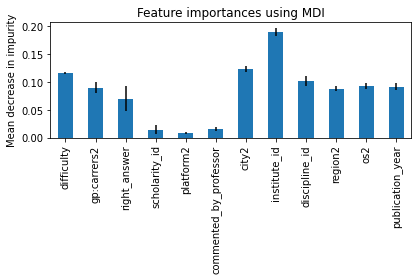

In [17]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [30]:
def fit_and_graph():
    sns.set(rc = {'figure.figsize':(4, 4)})

    abc.fit(X_train, y_train)
    y_pred = abc.predict(X_test)

    acc = accuracy_score(y_pred, y_test)
    print('accuracy: ', acc)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')

In [14]:
from sklearn.ensemble import IsolationForest

In [ ]:
columns = ['difficulty', 'right_answer',  'institute_id', 'discipline_id', 'os2', 'mean_acertou']

percentages = []

for column in columns:

    model=IsolationForest(n_estimators=50, max_samples=2000000, contamination=float(0.1),max_features=1.0, random_state=20)
    model.fit(X[[column]].values)

    new_column = str(column+'_anomaly')
    X[new_column]=model.predict(X[['difficulty']])

    anomaly=X.loc[X[new_column]==-1]

    cant_anomaly = int(anomaly.iloc[:, :1].count())

    percentage = ('percentage of ', column,' outliers : ', ( (cant_anomaly) * 100 / len(X[new_column]) ).real )
    
    percentages.append(percentage)

In [22]:
percentages

[('percentage of ', 'difficulty', ' outliers : ', 4.4702),
 ('percentage of ', 'right_answer', ' outliers : ', 0.0),
 ('percentage of ', 'institute_id', ' outliers : ', 0.13145),
 ('percentage of ', 'discipline_id', ' outliers : ', 0.13145),
 ('percentage of ', 'os2', ' outliers : ', 0.13145),
 ('percentage of ', 'mean_acertou', ' outliers : ', 99.86855)]

In [23]:
newdt = pd.concat([X, y], axis=1)

In [24]:
newdt['acertou'].count()

2000000

In [25]:
newdt = newdt[newdt.difficulty_anomaly != -1]
newdt = newdt[newdt.right_answer_anomaly != -1]
newdt = newdt[newdt.institute_id_anomaly != -1]
newdt = newdt[newdt.discipline_id_anomaly != -1]
newdt = newdt[newdt.os2_anomaly != -1]

In [26]:
newdt['acertou'].count()

1910596

In [65]:

X = newdt[['difficulty', 'gp:carrers2', 'right_answer', 'scholarity_id', 'commented_by_professor',
         'institute_id', 'discipline_id', 'os2', 'mean_acertou']]

         
y = newdt['acertou']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

accuracy:  0.6836124777556788


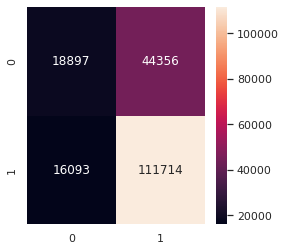

In [68]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

abc = BaggingClassifier(base_estimator=
                        GradientBoostingClassifier(n_estimators = 330, min_samples_split=2, learning_rate=0.07),
                         n_estimators=5)

fit_and_graph()

In [69]:
Xsubmit = dtsubmit[['difficulty', 'gp:carrers2', 'right_answer', 'scholarity_id', 'commented_by_professor',
                    'institute_id', 'discipline_id', 'os2', 'mean_acertou']]
Xsubmit = Xsubmit.fillna(0)

ysubmit = abc.predict(Xsubmit).astype(int)
ysubmit = pd.DataFrame(ysubmit)

In [70]:
ysubmit.to_csv('ysubmit.csv', index=False, header=False)

*** final score in the competition: 0.80259 ***